In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import isfile, join

import time

sns.set()

In [2]:
%matplotlib inline

## 1. Load prepared data

Load song master table and reduced table

In [3]:
# Load master song table with added metadata
master = pd.read_pickle('../data/master200.pkl')
master_reduced = pd.read_pickle('../data/final/master_reduced.pkl')

song_ids = master_reduced.index.values
cont_feats = list(master_reduced.drop(['artist_name', 'album_name'], 1).columns)

In [4]:
master.head(3)

,artist_name,artist_uri,track_name,album_uri,duration_ms,album_name,count,track_uri,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,artist_genres,artist_popularity,album_genres,album_popularity,album_release_date
song_id,,,,,,,,,,,,,,,,,,,,,
0,Sidney Bechet's Blue Note Jazzmen,spotify:artist:2XouUSO0EAJ9gMMoHiXqMt,Muskrat Ramble,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,220293,Jazz Classics,1,spotify:track:0002yNGLtYSYtc0X6ZnFvp,0.455,0.623,...,0.903,0.634,0.951,182.345,4,[],18,[],37,1993-01-01
159583,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Blue Horizon,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,264933,Jazz Classics,5,spotify:track:1EWPMNHfdVNJwBpG9BcxXB,0.327,0.372,...,0.835,0.153,0.380,66.036,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01
271702,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Blame It On The Blues - Alternate Take,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,175893,Jazz Classics,1,spotify:track:26N4Y48EjprAtvlY6yWZTA,0.574,0.606,...,0.948,0.349,0.965,101.361,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01


In [5]:
scaled_cont = np.load('../data/final/scaled_continuous_17wide.npy').reshape((-1, 17))
encoded_artists = np.load('../data/final/encoded_artists_20wide.npy').reshape((-1, 20))

In [6]:
scaled_cont.shape, encoded_artists.shape

((213675, 17), (213675, 20))

In [7]:
merged = np.hstack((scaled_cont, encoded_artists))
merged.shape

(213675, 37)

# 2. HDBSAN clustering
- The HDBSCAN clustering library: https://hdbscan.readthedocs.io/en/latest/
- How HDBSCAN works: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
- Parameter selection: https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

In [9]:
import hdbscan as h

In [10]:
hdb = h.HDBSCAN(min_cluster_size = 500, )

In [11]:
hdb.fit(merged)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=500, min_samples=None, p=None,
        prediction_data=False)

Number of clusters

In [21]:
np.max(hdb.labels_)+1

2

Specify number of clusters in HDBSCAN: extract from hierarchical tree

In [22]:
from scipy.cluster.hierarchy import fcluster

In [23]:
Z = hdb.single_linkage_tree_.to_numpy()
labels = fcluster(Z, 10, criterion='maxclust')

Fit on just continuous features

In [28]:
hdb2 = h.HDBSCAN(min_cluster_size = 500)

In [29]:
hdb2.fit(merged)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=500, min_samples=None, p=None,
        prediction_data=False)

Number of clusters

In [30]:
np.max(hdb2.labels_)+1

2

Specify number of clusters in HDBSCAN: extract from hierarchical tree

In [31]:
from scipy.cluster.hierarchy import fcluster

In [38]:
Z2 = hdb2.single_linkage_tree_.to_numpy()
labels2 = fcluster(Z2, 10, criterion='maxclust')

In [39]:
np.unique(labels2, return_counts = True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
 array([213666,      1,      1,      1,      1,      1,      1,      1,
             1,      1]))

Visualise clusters with t-SNE

In [8]:
# Data already shuffled, so we can pull a random subset of train data for visualisation
np.random.seed(42)
tsne_ind = np.random.choice(np.arange(merged.shape[0]), 10000)

Code heavily borrowed from:  
https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [9]:
from sklearn.manifold import TSNE
time_start = time.time()
#tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsne = TSNE(n_components = 2, verbose = 1, n_iter = 300)
tsne_results = tsne.fit_transform(merged[tsne_ind])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.052s...
[t-SNE] Computed neighbors for 10000 samples in 8.319s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.238428
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.998817
[t-SNE] KL divergence after 300 iterations: 3.408233
t-SNE done! Time elapsed: 

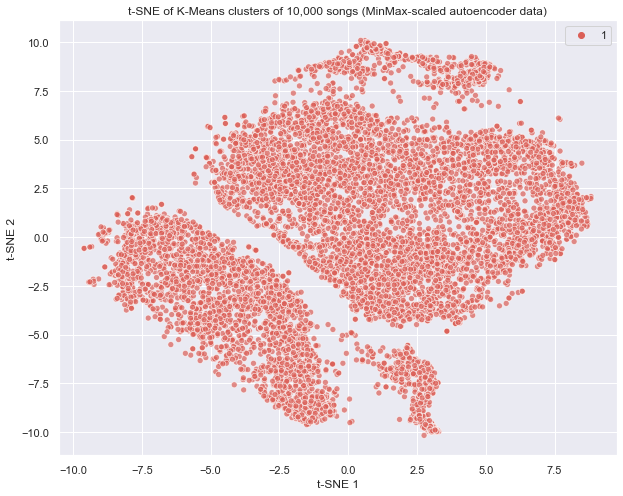

In [37]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[:, 0], 
    y = tsne_results[:, 1],
    hue = labels2[tsne_ind],
    palette = sns.color_palette("hls", len(np.unique(labels2[tsne_ind]))),
    legend = "full",
    alpha = 0.7
)

ax.set(title = 't-SNE of K-Means clusters of 10,000 songs (MinMax-scaled autoencoder data)', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')
plt.savefig('tsne.png')
plt.savefig('tsne.pdf')

# 3. Spectral clustering
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering

Apply clustering to a projection of the normalized Laplacian.

In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster. For instance when clusters are nested circles on the 2D plane.

In [40]:
from sklearn.cluster import SpectralClustering

In [41]:
spec = SpectralClustering(n_clusters = 10, n_jobs = -1)

In [ ]:
spec.fit(merged)

In [ ]:
spec_labels = spec.labels_

In [ ]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[:, 0], 
    y = tsne_results[:, 1],
    hue = spec_labels[tsne_ind],
    palette = sns.color_palette("hls", len(np.unique(spec_labels[tsne_ind]))),
    legend = "full",
    alpha = 0.7
)

ax.set(title = 't-SNE of K-Means clusters of 10,000 songs (MinMax-scaled autoencoder data)', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')
plt.savefig('tsne.png')
plt.savefig('tsne.pdf')

# 4. DBSCAN
**Without the H!**
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN

In [10]:
from sklearn.cluster import DBSCAN

In [11]:
db = DBSCAN(min_samples = 500, n_jobs = -1)

In [12]:
db.fit(merged)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=100, metric='euclidean',
       metric_params=None, min_samples=500, n_jobs=-1, p=None)

In [13]:
db_labels = db.labels_

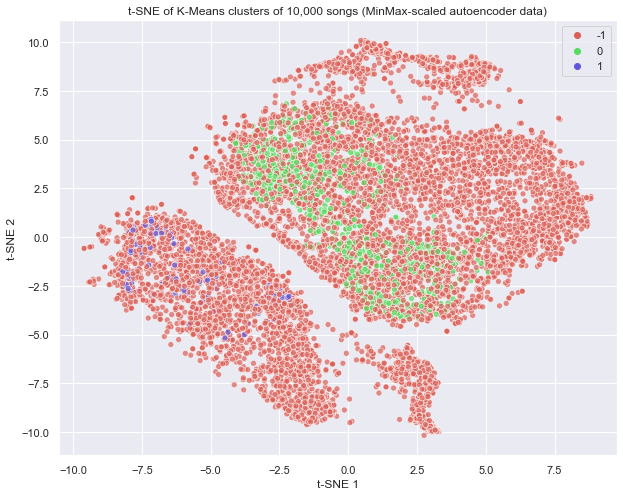

In [14]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[:, 0], 
    y = tsne_results[:, 1],
    hue = db_labels[tsne_ind],
    palette = sns.color_palette("hls", len(np.unique(db_labels[tsne_ind]))),
    legend = "full",
    alpha = 0.7
)

ax.set(title = 't-SNE of K-Means clusters of 10,000 songs (MinMax-scaled autoencoder data)', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')
plt.savefig('tsne.png')
plt.savefig('tsne.pdf')

# K-Means Clustering
Use data encoded into compressed representation to fit a clustering algorithm to group songs.

The number of clusters here maps directly to the number of families of playlists we can generate. Every song will be predicted to belong to a cluster, and the rest of the playlist generated with songs from that cluster.  
  
Read about K-Means:
- https://stats.stackexchange.com/questions/78313/clustering-inertia-formula-in-scikit-learn
- https://pythonprogramminglanguage.com/How-is-the-k-nearest-neighbor-algorithm-different-from-k-means-clustering/
- https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_jobs = -1, n_clusters = 10, n_init = 20, 
                max_iter = 300, random_state = 42, verbose = 0)

kmeans.fit(merged)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=20, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [17]:
cluster_centers = kmeans.cluster_centers_

k_labels = kmeans.labels_

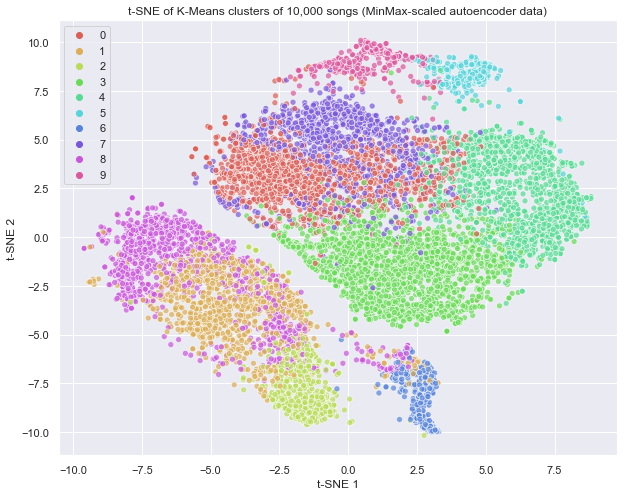

In [18]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[:, 0], 
    y = tsne_results[:, 1],
    hue = k_labels[tsne_ind],
    palette = sns.color_palette("hls", len(np.unique(k_labels[tsne_ind]))),
    legend = "full",
    alpha = 0.7
)

ax.set(title = 't-SNE of K-Means clusters of 10,000 songs (MinMax-scaled autoencoder data)', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')
plt.savefig('tsne.png')
plt.savefig('tsne.pdf')

In [271]:
# Sizes of fit clusters (num songs in each)
clust, count = np.unique(merged_auto_labels, return_counts = True)
for cl, co in zip(clust, count):
    print(cl, ':', co)

0 : 6878
1 : 5737
2 : 3189
3 : 6406
4 : 5685
5 : 8702
6 : 7027
7 : 7014
8 : 7131
9 : 6942
10 : 7198
11 : 1916
12 : 7471
13 : 7667
14 : 4214
15 : 7141
16 : 8386
17 : 4726
18 : 6564
19 : 3334


## t-SNE of K-Means clusters on scaled data
#### T-Distributed Stochastic Neighbouring Entities
To visualise song clustering from K-Means in a t-sne embedded space

In [272]:
from sklearn.manifold import TSNE

In [273]:
# Data already shuffled, so we can pull a random subset of train data for visualisation
np.random.seed(42)
tsne_ind = np.random.choice(np.arange(merged_auto.shape[0]), 10000)

auto_subset = merged_auto[tsne_ind, :]
auto_subset_clusters = merged_auto_labels[tsne_ind]

Code heavily borrowed from:  
https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [274]:
time_start = time.time()
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(auto_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 1.389s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.085168
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.923927
[t-SNE] KL divergence after 300 iterations: 3.129362
t-SNE done! Time elapsed:

In [275]:
auto_subset = np.concatenate((auto_subset, tsne_results), axis = 1)

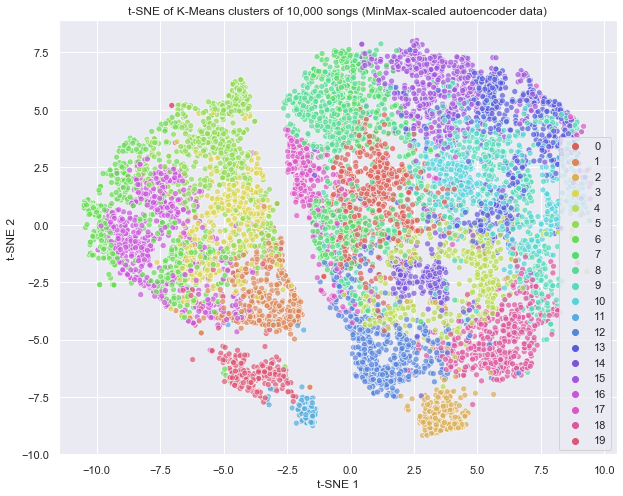

In [281]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = auto_subset[:, -2], 
    y = auto_subset[:, -1],
    hue = auto_subset_clusters,
    palette = sns.color_palette("hls", 20),
    legend = "full",
    alpha = 0.7
)

ax.set(title = 't-SNE of K-Means clusters of 10,000 songs (MinMax-scaled autoencoder data)', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')
plt.savefig('tsne.png')
plt.savefig('tsne.pdf')

# TODO: The below has not been updated!
## Use K-Means to generate playlist from cold start

Given a set of start songs for the cold start, there are some potential ways of populating a playlist. For each of those songs, predict the cluster to which it belongs, then either:
- Pull songs from the mode cluster (i.e. the most common), if tied pick a random cluster and get all new songs from there.
- **Our implementation**: Pull randomly from one of the predicted clusters each time, with probability weighted equal to the number of times each cluster was predicted.
- Instead of predicting the single cluster of each start song, get its distance to all clusters, sum them up, average them, and use that to determine the closet cluster(s) of the songs as a group, then pull from either the closest one or closest $n$ with some weighting scheme (e.g. by distance).

Should handle running out of songs to sample from, i.e. if we exhaust the cluster when pulling new songs to populate the playlist, but with a reasonably low number of clusters there are so many it seems very unlikely any playlist will be so long it exhausts any cluster.

Algorithm to use a KMeans clustering model to generate a playlist. Given a fit KMeans and a set of seed songs with which to start the playlist, the algorithm predicts the cluster of each seed song using the model. It then generates a sequence of the cluster from which it will pull each new song in the playlist, weighting the probability of each cluster by the number of seed songs that belongs to that cluster. Iterating through that sequence, it pulls a random song from the respective cluster, removing it from the next iteration to avoid duplicate songs in the new playlist (however unlikely, with the dataset size). Finally, it returns the new songs in the playlist in terms of their indices in the test set and their song id in the master songs table.

In [21]:
'''
Function to generate a new playlist based on a given set of starting songs
Returns the list new songs, both as their indices in the train set and as song ids in master
Note: returns are exclusive of seed songs, so need to prepend those first if to be included
'''
def generate_playlist(start_songs, playlist_length = 20):
    # Ensure proper dimensions of songs: handles list of individual songs or set of songs
    start_clusters = kmeans.predict(np.reshape(start_songs, (len(start_songs), -1)))
    print('Starting songs clusters:', start_clusters)

    # Get count of each start cluster and its respective weight of total
    start_cluster, cluster_count = np.unique(start_clusters, return_counts = True)
    start_cluster, cluster_count = list(start_cluster), list(cluster_count)
    cluster_weight = cluster_count / np.sum(cluster_count)
    print('Cluster, Counts, Weights:', start_cluster, cluster_count, cluster_weight)

    # For each cluster from which we will sample, get indices of all songs in train set
    cluster_song_ind = [np.argwhere(train_labels == c).reshape((-1,)) for c in start_cluster]
    # Flatten component arrays
    print(len(cluster_song_ind), 'clusters with # songs each:', [len(clust) for clust in cluster_song_ind])

    # Sample list of clusters with which to populate playlist
    new_song_clusters = np.random.choice(start_cluster, size = playlist_length, p = cluster_weight)
    print('\nNew song clusters:', new_song_clusters)
    
    new_song_train_inds = np.empty((playlist_length), 'int')
    new_song_ids = np.empty((playlist_length), 'int')

    # For each new song
    print('\nRandom song from each random cluster in order:\ncluster train_ind cluster_size')
    for i, ns_c in enumerate(new_song_clusters):
        # Get index of new song cluster from list of train set song indices of each cluster to use
        ns_c_ind = start_cluster.index(ns_c)

        # Get training set index of a random new song from current cluster
        ns_train_ind = np.random.choice(cluster_song_ind[ns_c_ind], size = 1)[0]
        # Remove this song from the temporary list of cluster songs to avoid repeating songs
        cluster_song_ind[ns_c_ind] = cluster_song_ind[ns_c_ind][cluster_song_ind[ns_c_ind] != ns_train_ind]

        # Add song train set index to list of songs in new playlist
        new_song_train_inds[i] = ns_train_ind

        # Get actual song id from master songs table and add to list of new songs
        new_song_ids[i] = train_songids[ns_train_ind]

        # Print cluster of new song, its index in train, and new length of cluster
        print(ns_c, ns_train_ind, len(cluster_song_ind[ns_c_ind]))

    print('\nNew song train indices:\n', new_song_train_inds)
    print('\nNew song IDs from master table:\n', new_song_ids)
    
    return new_song_train_inds, new_song_ids


Run the function to showase how the baseline model for playlist generation works, and show the example generated playlist based on a set of previously unseen seed/starter songs.

In [22]:
# Number of songs with which to seed
songs_seed = 3

# Showcase different ways of passing in songs (list of arrays/vectors, whole array)
#start_songs = [test[i:i+1, :] for i in range(songs_seed)]
start_songs = test[0:songs_seed, :]

# Run function to generate playlist
playlist_train_indices, playlist_song_ids = generate_playlist(start_songs, 20)

Starting songs clusters: [0 0 3]
Cluster, Counts, Weights: [0, 3] [2, 1] [0.66666667 0.33333333]
2 clusters with # songs each: [66979, 175581]

New song clusters: [3 0 3 3 0 0 3 3 3 3 3 3 0 0 0 0 0 3 3 3]

Random song from each random cluster in order:
cluster train_ind cluster_size
3 778403 175580
0 373778 66978
3 913673 175579
3 628419 175578
0 353901 66977
0 100063 66976
3 384855 175577
3 323133 175576
3 387588 175575
3 306768 175574
3 183521 175573
3 31459 175572
0 75990 66975
0 890223 66974
0 221048 66973
0 614152 66972
0 698068 66971
3 720405 175571
3 607844 175570
3 552151 175569

New song train indices:
 [778403 373778 913673 628419 353901 100063 384855 323133 387588 306768
 183521  31459  75990 890223 221048 614152 698068 720405 607844 552151]

New song IDs from master table:
 [781791 375439 917610 631163 355467 100504 386561 324567 389300 308130
 184357  31600  76318 894070 222045 616840 701111 723540 610510 554565]


Show generated playlist as list of songs with metadata. Our seed/starter songs appear first, then the rest in the sequence in which they were generated.  
  
*Note: the K-Means and algorithm only use numeric values, so the non-numeric data below can be misleading as it was not taken into account.*

In [23]:
# Playlist as list of songs with metadata
pd.read_pickle('../data/master200.pkl').loc[np.append(test_songids[0:3], playlist_song_ids)]

,artist_name,artist_uri,track_name,album_uri,duration_ms,album_name,count,track_uri,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,artist_genres,artist_popularity,album_genres,album_popularity,album_release_date
song_id,,,,,,,,,,,,,,,,,,,,,
554407,Mint Condition,spotify:artist:4MT97VeycuegSicrrphisJ,Definition Of A Band,spotify:album:7a19lFps8uDiFZr1bhJmmY,59866,Definition Of A Band,1,spotify:track:4IAWtxmJ13hXTlxwuG77M0,0.434,0.578,...,0.821000,0.0713,0.66200,97.430,3,"['dance pop', 'funk', 'hip pop', 'minneapolis ...",54,[],44,1996-01-01
774639,"Nature Sounds Relaxation: Music for Sleep, Med...",spotify:artist:1qzR1EqCmsTDa9AwBLTT4b,"Nature Sounds – Waterfall, Trickling Cascades ...",spotify:album:57nnU1noZOVKKR7yzonkWD,228893,Nature Sounds,1,spotify:track:60QW1IideSuHPbuoz7dfZh,0.096,1.000,...,0.918000,0.9770,0.00001,160.678,1,"['environmental', 'sleep']",34,[],32,2011-11-01
239936,Brainstorm,spotify:artist:6JPBUFrfF5w5whOPk2w0kp,You Put A Charge In My Life,spotify:album:4tLBJzaV71qm3TyepiEIBy,251733,Funky Entertainment,3,spotify:track:1r69KR1iUoLfoN4Z44Okca,0.590,0.527,...,0.000000,0.7550,0.73100,144.911,4,['p funk'],35,[],35,1979
781791,One-Eyed Doll,spotify:artist:4w2wxHsHxLp64aXeZ9v1nW,Nudie Bar,spotify:album:6rxmXoRR5WWmSKQe3682A2,173026,Hole,1,spotify:track:63tL5Gza0dbe3zBNIniuOL,0.523,0.930,...,0.006690,0.3310,0.83700,160.161,4,"['hard glam', 'steampunk', 'texas punk']",31,[],19,2007-02-20
375439,El Huervo,spotify:artist:2gG1LfmQPkHZNptgVpYlpr,Rust,spotify:album:10sWEyUUMMS1i26Iaw94lk,297473,Rust B/W Ghost,6,spotify:track:2uA9EGy7KifPvk2F342IvR,0.745,0.762,...,0.862000,0.1390,0.31100,92.493,4,[],45,[],38,2015-10-05
917610,Cathedral,spotify:artist:5O7ziOtiFUyRMBJN1J4Tpv,Hopkins (Witchfinder General),spotify:album:1Sks1BI0egVhaE9zni8ddf,318280,The Serpent's Gold,1,spotify:track:77cgeHw3mJPfKjivt1HRk1,0.312,0.969,...,0.008850,0.2900,0.22700,137.177,4,"['death metal', 'doom metal', 'metal', 'sludge...",33,[],18,2004
631163,We As Human,spotify:artist:6FFTGpuvFDztqTz4t1Hqy9,We Fall Apart,spotify:album:79dn7GARLrAgKx28cwvLea,230786,We As Human,46,spotify:track:4tMOesd7zi9cLH7KZh0DcP,0.482,0.544,...,0.000000,0.1310,0.40400,119.957,4,"['christian alternative rock', 'christian hard...",44,[],47,2011-06-21
355467,Jaws Underground,spotify:artist:0cqwBctx3ja0npObrVSfoU,The Rules,spotify:album:52lCoLmoM1AqGgsYBA94wi,531200,Still Alive,1,spotify:track:2kVexGVnckELYvAxVau9lo,0.530,0.992,...,0.832000,0.3400,0.12500,150.018,4,['deep full on'],8,[],3,2010-12-16
100504,Cascandy,spotify:artist:2jSv6vhlLlg9Urqffm5DwO,Four - Flip,spotify:album:3emOirW73LwC74J6jkVmfr,464640,Collection One Compilation,1,spotify:track:0mDfDoK5GBLJ5xQW7zv14f,0.869,0.614,...,0.779000,0.1150,0.25600,125.204,4,[],24,[],0,2011-05-02
